#### 1. Importação das Classes

In [1]:
import numpy as np
import pandas as pd
from math import e
from scipy.stats import chi2
from scipy.stats import laplace
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt
from funcoes import gradient_descent, l2_gradient, proj, min_l2_norm, gerarTabelas, mre, chi, pValue

In C:\Users\edvar.filho\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\edvar.filho\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\edvar.filho\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\edvar.filho\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be remove

---
#### 2. Dataset e valores reais

In [2]:
dataset = pd.read_csv('dataset3.csv').values

In [3]:
N = dataset.shape[0]/2

In [4]:
tabsCont = gerarTabelas(dataset)

In [5]:
quiQuadrado= chi(tabsCont)

In [6]:
pValor = pValue(quiQuadrado, 2)

In [7]:
logPValor = np.log10(pValor)

In [8]:
budgets = [0.01, 0.05, 0.1, np.log(2), 1]

---
#### 3. Abordagem proposta (ruído na tabela de contingência) - Mecanismo Geométrico

In [9]:
sensibilidadeGeom = 1
tabelasMedias = []
for epsilon in budgets:
    tabelas = []
    for i in range(0, 1000):
        tabelasRuidosas = []
        for j in range(0, len(tabsCont)):
            tabela = np.array(tabsCont[j])
            p = 1 - np.exp([[-epsilon,-epsilon,-epsilon],[-epsilon,-epsilon,-epsilon]])
            ruidoGeo = np.random.geometric(p, size=tabela.shape) - np.random.geometric(p, size=tabela.shape)
            tabelaGeo = tabela + ruidoGeo
            desired_sum = np.sum(tabelaGeo, axis=1)
            for linha in range(0, tabelaGeo.shape[0]):
                tabelaGeo[linha] = min_l2_norm(tabelaGeo[linha], desired_sum[linha], min_value=0)
            tabelasRuidosas.append(tabelaGeo)
        if((i+1)%100 == 0):
            print(i+1)
        tabelas.append(tabelasRuidosas)
    tabelas = np.array(tabelas)
    tabelasMediasBudget = np.mean(tabelas, axis = 0).astype(int)
    tabelasMedias.append(tabelasMediasBudget)
    print('Epsilon: ',epsilon, ' -> OK')
tabelasMedias = np.array(tabelasMedias)

100
200
300
400
500
600
700
800
900
1000
Epsilon:  0.01  -> OK
100
200
300
400
500
600
700
800
900
1000
Epsilon:  0.05  -> OK
100
200
300
400
500
600
700
800
900
1000
Epsilon:  0.1  -> OK
100
200
300
400
500
600
700
800
900
1000
Epsilon:  0.6931471805599453  -> OK
100
200
300
400
500
600
700
800
900
1000
Epsilon:  1  -> OK


In [10]:
quiQuadradoGeoP = []
pValorGeoP = []
logPValorGeoP = []
for tabelas in tabelasMedias:
    qui = chi(tabelas)
    p = pValue(qui, 2)
    log = np.log10(p)
    quiQuadradoGeoP.append(qui)
    pValorGeoP.append(p)
    logPValorGeoP.append(log)
quiQuadradoGeoP = np.array(quiQuadradoGeoP)
pValorGeoP = np.array(pValorGeoP)
logPValorGeoP = np.log10(pValorGeoP)

In [11]:
MSEQuiGeoP, MAEQuiGeoP, MREQuiGeoP = [], [], []
MSEPGeoP, MAEPGeoP, MREPGeoP = [], [], []
MSELogGeoP, MAELogGeoP, MRELogGeoP = [], [], []
for i in range(0, len(budgets)):
    MSEQuiGeoP.append(mean_squared_error(quiQuadradoGeoP[i], quiQuadrado))
    MAEQuiGeoP.append(mean_absolute_error(quiQuadradoGeoP[i], quiQuadrado))
    MREQuiGeoP.append(mre(quiQuadradoGeoP[i], quiQuadrado))
    MSEPGeoP.append(mean_squared_error(pValorGeoP[i], pValor))
    MAEPGeoP.append(mean_absolute_error(pValorGeoP[i], pValor))
    MREPGeoP.append(mre(pValorGeoP[i], pValor))
    MSELogGeoP.append(mean_squared_error(logPValorGeoP[i], logPValor))
    MAELogGeoP.append(mean_absolute_error(logPValorGeoP[i], logPValor))
    MRELogGeoP.append(mre(logPValorGeoP[i], logPValor))

---
#### 4. Abordagem Yamamoto et. al. (ruído nas métricas) - Mecanismo de Laplace

In [12]:
sensibilidadeY = np.log10(e*(2*N)/(N+2))

In [13]:
logPValorLapY = []
for epsilon in budgets:
    logs = []
    for i in range(0, 1000):
        ruido = laplace.rvs(loc = 0, scale = sensibilidadeY/epsilon, size = logPValor.shape[0])
        logPValorRuid = logPValor + ruido
        logs.append(logPValorRuid)
    logPValorLapY.append(logs)
    print('Epsilon: ',epsilon, ' -> OK')
logPValorLapY = np.array(logPValorLapY)
logPValorLapY = np.mean(logPValorLapY, axis = 1)

Epsilon:  0.01  -> OK
Epsilon:  0.05  -> OK
Epsilon:  0.1  -> OK
Epsilon:  0.6931471805599453  -> OK
Epsilon:  1  -> OK


In [14]:
MSELogLapY, MAELogLapY, MRELogLapY = [], [], []
for i in range(0, len(budgets)):
    MSELogLapY.append(mean_squared_error(logPValorLapY[i], logPValor))
    MAELogLapY.append(mean_absolute_error(logPValorLapY[i], logPValor))
    MRELogLapY.append(mre(logPValorLapY[i], logPValor))

---
#### 5. Abordagem Fienberg

In [15]:
sensibilidadeF = (4*N)/(N+2)

In [16]:
logPValorLapF = []
for epsilon in budgets:
    logs = []
    for i in range(0, 1000):
        ruido = laplace.rvs(loc = 0, scale = sensibilidadeF/epsilon, size = logPValor.shape[0])
        logPValorRuid = logPValor + ruido
        logs.append(logPValorRuid)
    logPValorLapF.append(logs)
    print('Epsilon: ',epsilon, ' -> OK')
logPValorLapF = np.array(logPValorLapF)
logPValorLapF = np.mean(logPValorLapF, axis = 1)

Epsilon:  0.01  -> OK
Epsilon:  0.05  -> OK
Epsilon:  0.1  -> OK
Epsilon:  0.6931471805599453  -> OK
Epsilon:  1  -> OK


In [17]:
MSELogLapF, MAELogLapF, MRELogLapF = [], [], []
for i in range(0, len(budgets)):
    MSELogLapF.append(mean_squared_error(logPValorLapF[i], logPValor))
    MAELogLapF.append(mean_absolute_error(logPValorLapF[i], logPValor))
    MRELogLapF.append(mre(logPValorLapF[i], logPValor))

---
#### 6. Comparação dos erros

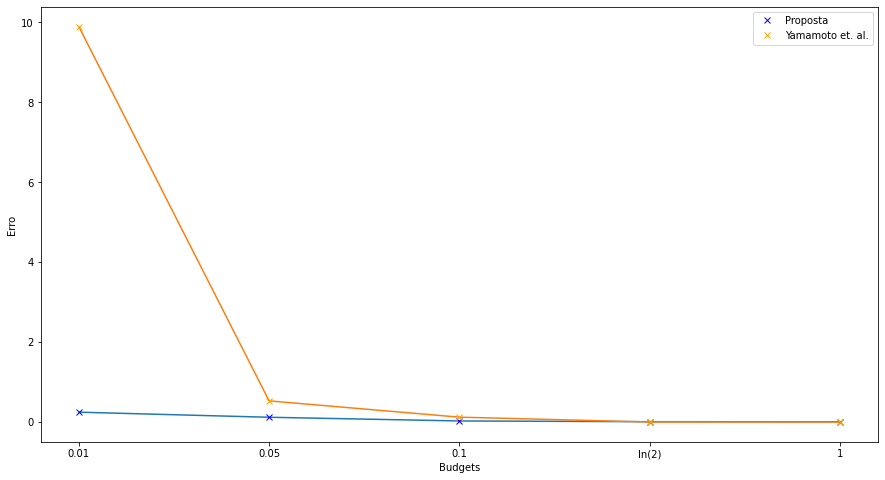

In [18]:
plt.figure(figsize=(15,8))
bud = ['0.01', '0.05', '0.1', 'ln(2)', '1']
plt.plot(bud, MSELogGeoP)
plt.plot(bud, MSELogGeoP, 'x', color='blue', label='Proposta')
plt.plot(bud, MSELogLapY)
plt.plot(bud, MSELogLapY, 'x', color='orange', label='Yamamoto et. al.')
#plt.plot(bud, MSELogLapF)
#plt.plot(bud, MSELogLapF, 'x', color='green', label='Fienberg et. al.')
plt.legend()
plt.xlabel('Budgets')
plt.ylabel('Erro')
plt.savefig('Dataset 3/MSE - Comparacao.png')

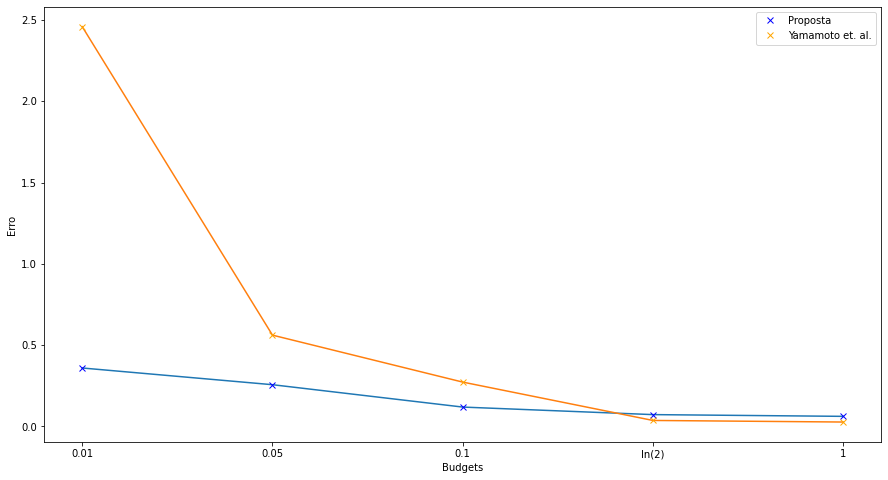

In [19]:
plt.figure(figsize=(15,8))
bud = ['0.01', '0.05', '0.1', 'ln(2)', '1']
plt.plot(bud, MAELogGeoP)
plt.plot(bud, MAELogGeoP, 'x', color='blue', label='Proposta')
plt.plot(bud, MAELogLapY)
plt.plot(bud, MAELogLapY, 'x', color='orange', label='Yamamoto et. al.')
#plt.plot(bud, MAELogLapF)
#plt.plot(bud, MAELogLapF, 'x', color='green', label='Fienberg et. al.')
plt.legend()
plt.xlabel('Budgets')
plt.ylabel('Erro')
plt.savefig('Dataset 3/MAE - Comparacao.png')

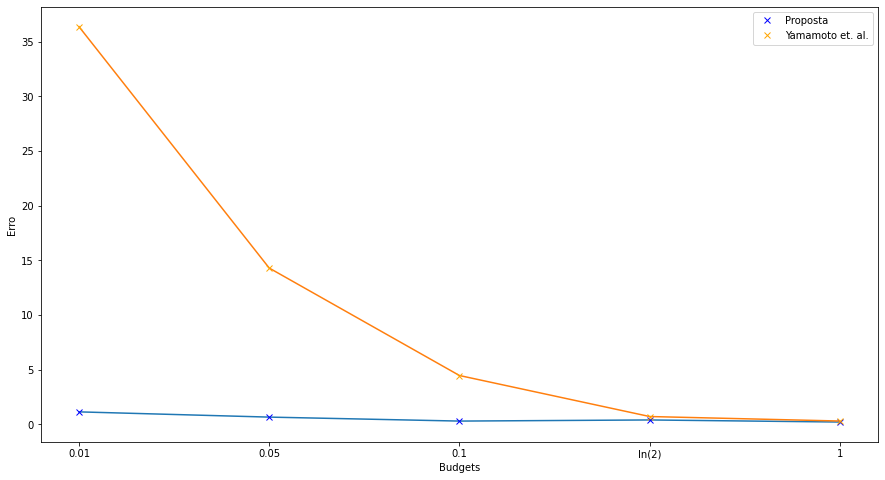

In [20]:
plt.figure(figsize=(15, 8))
bud = ['0.01', '0.05', '0.1', 'ln(2)', '1']
plt.plot(bud, MRELogGeoP)
plt.plot(bud, MRELogGeoP, 'x', color='blue', label='Proposta')
plt.plot(bud, MRELogLapY)
plt.plot(bud, MRELogLapY, 'x', color='orange', label='Yamamoto et. al.')
#plt.plot(bud, MRELogLapF)
#plt.plot(bud, MRELogLapF, 'x', color='green', label='Fienberg et. al.')
plt.legend()
plt.xlabel('Budgets')
plt.ylabel('Erro')
plt.savefig('Dataset 3/MRE - Comparacao.png')

---
#### 7. Visualização dos dados

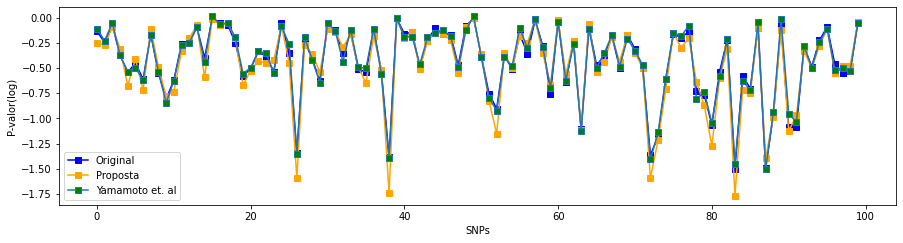

In [21]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
ax1.plot(np.arange(len(logPValor)), logPValor, marker='s', color='blue', label='Original')
ax1.plot(np.arange(len(logPValor)), logPValorGeoP[4], marker='s', color='orange', label='Proposta')
ax1.plot(np.arange(len(logPValor)), logPValorLapY[4], marker='s', markerfacecolor='green', label='Yamamoto et. al')
#ax1.plot(np.arange(len(logPValor)), logPValorLapF[0], marker='s', markerfacecolor='black', label='Fienberg et. al')
plt.xlabel('SNPs')
plt.ylabel('P-valor(log)')
plt.legend()
plt.savefig('Dataset 3/1 - PValor.png')

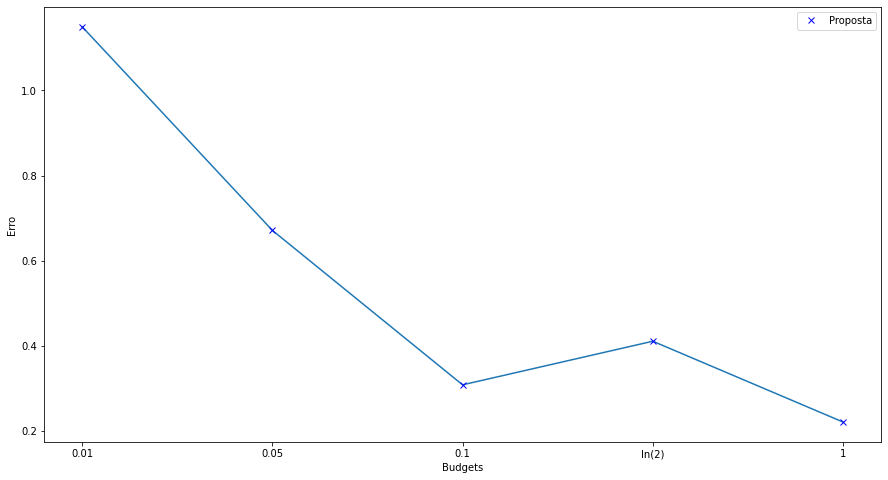

In [22]:
plt.figure(figsize=(15, 8))
bud = ['0.01', '0.05', '0.1', 'ln(2)', '1']
plt.plot(bud, MRELogGeoP)
plt.plot(bud, MRELogGeoP, 'x', color='blue', label='Proposta')
#plt.plot(bud, MRELogLapY)
#plt.plot(bud, MRELogLapY, 'x', color='orange', label='Yamamoto et. al.')
#plt.plot(bud, MRELogLapF)
#plt.plot(bud, MRELogLapF, 'x', color='green', label='Fienberg et. al.')
plt.legend()
plt.xlabel('Budgets')
plt.ylabel('Erro')
plt.savefig('Dataset 3/MRE - Proposta.png')

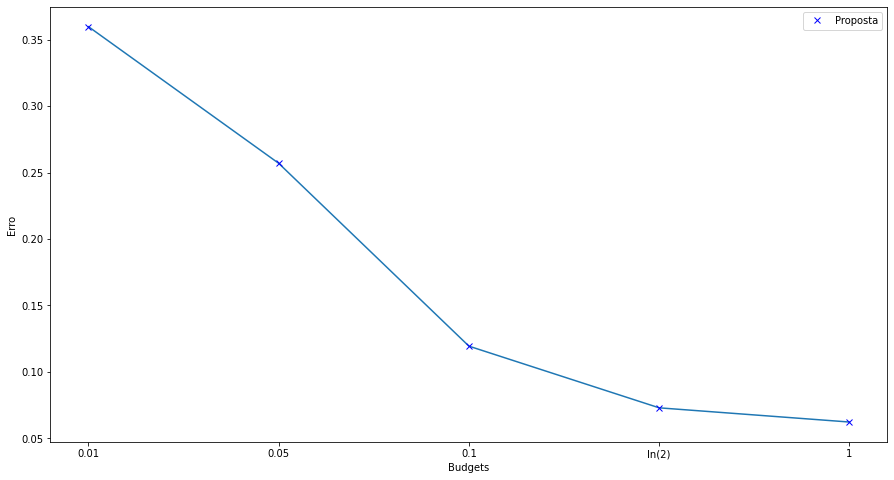

In [23]:
plt.figure(figsize=(15, 8))
bud = ['0.01', '0.05', '0.1', 'ln(2)', '1']
plt.plot(bud, MAELogGeoP)
plt.plot(bud, MAELogGeoP, 'x', color='blue', label='Proposta')
#plt.plot(bud, MRELogLapY)
#plt.plot(bud, MRELogLapY, 'x', color='orange', label='Yamamoto et. al.')
#plt.plot(bud, MRELogLapF)
#plt.plot(bud, MRELogLapF, 'x', color='green', label='Fienberg et. al.')
plt.legend()
plt.xlabel('Budgets')
plt.ylabel('Erro')
plt.savefig('Dataset 3/MAE - Proposta.png')

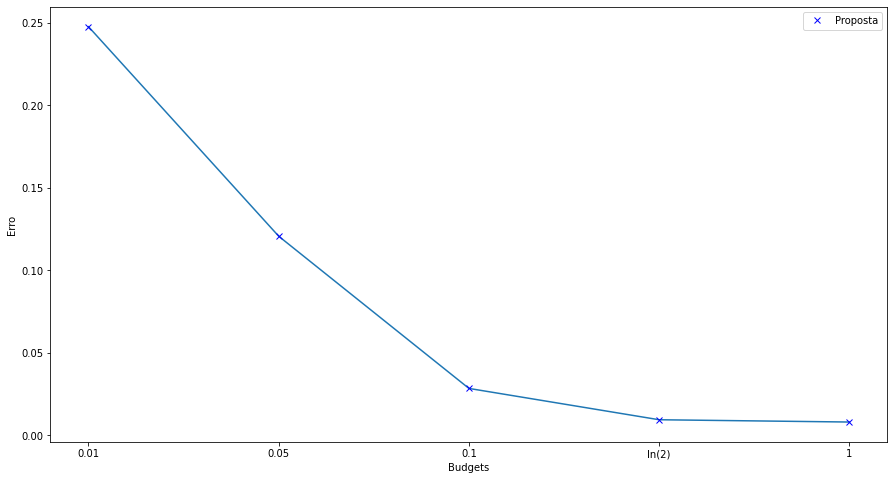

In [24]:
plt.figure(figsize=(15, 8))
bud = ['0.01', '0.05', '0.1', 'ln(2)', '1']
plt.plot(bud, MSELogGeoP)
plt.plot(bud, MSELogGeoP, 'x', color='blue', label='Proposta')
#plt.plot(bud, MRELogLapY)
#plt.plot(bud, MRELogLapY, 'x', color='orange', label='Yamamoto et. al.')
#plt.plot(bud, MRELogLapF)
#plt.plot(bud, MRELogLapF, 'x', color='green', label='Fienberg et. al.')
plt.legend()
plt.xlabel('Budgets')
plt.ylabel('Erro')
plt.savefig('Dataset 3/MSE - Proposta.png')

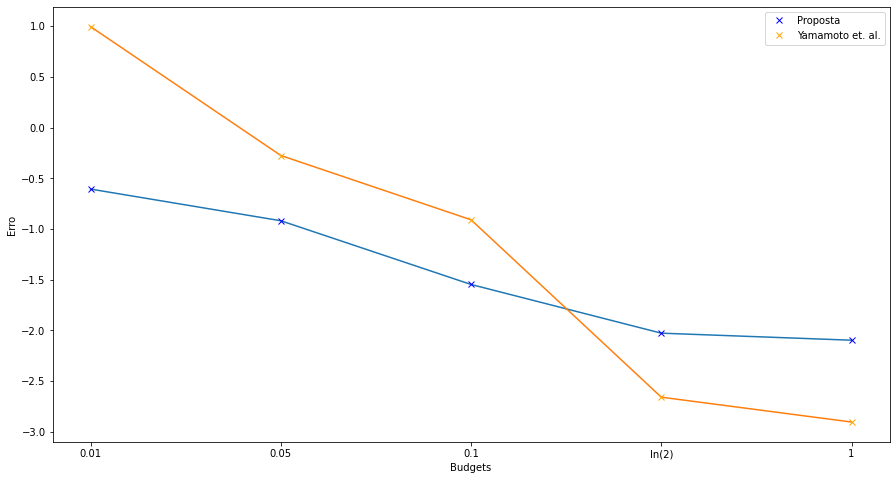

In [25]:
plt.figure(figsize=(15,8))
bud = ['0.01', '0.05', '0.1', 'ln(2)', '1']
plt.plot(bud, np.log10(MSELogGeoP))
plt.plot(bud, np.log10(MSELogGeoP), 'x', color='blue', label='Proposta')
plt.plot(bud, np.log10(MSELogLapY))
plt.plot(bud, np.log10(MSELogLapY), 'x', color='orange', label='Yamamoto et. al.')
plt.legend()
plt.xlabel('Budgets')
plt.ylabel('Erro')
plt.savefig('Dataset 3/MSE - Comparacao - Log.png')

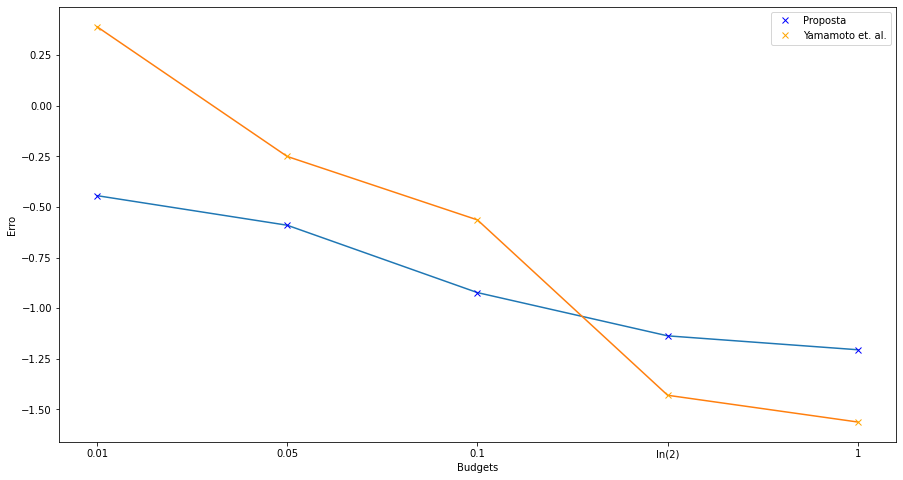

In [26]:
plt.figure(figsize=(15,8))
bud = ['0.01', '0.05', '0.1', 'ln(2)', '1']
plt.plot(bud, np.log10(MAELogGeoP))
plt.plot(bud, np.log10(MAELogGeoP), 'x', color='blue', label='Proposta')
plt.plot(bud, np.log10(MAELogLapY))
plt.plot(bud, np.log10(MAELogLapY), 'x', color='orange', label='Yamamoto et. al.')
plt.legend()
plt.xlabel('Budgets')
plt.ylabel('Erro')
plt.savefig('Dataset 3/MAE - Comparacao - Log.png')

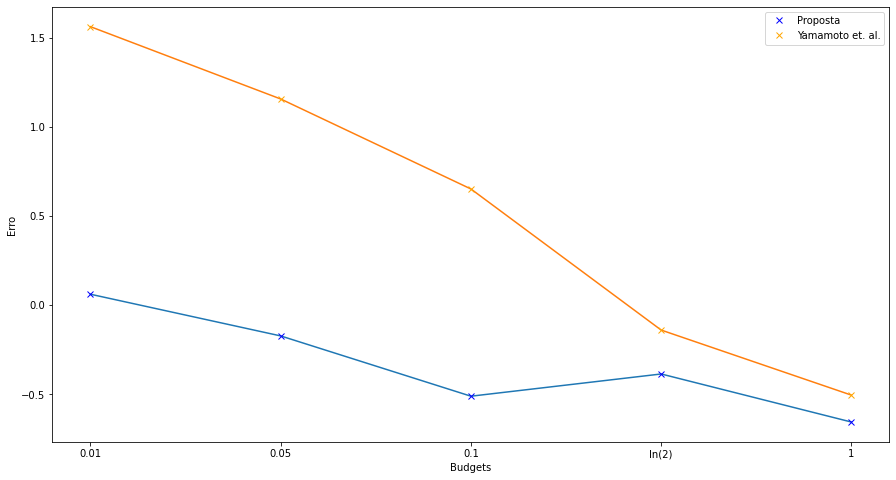

In [27]:
plt.figure(figsize=(15, 8))
bud = ['0.01', '0.05', '0.1', 'ln(2)', '1']
plt.plot(bud, np.log10(MRELogGeoP))
plt.plot(bud, np.log10(MRELogGeoP), 'x', color='blue', label='Proposta')
plt.plot(bud, np.log10(MRELogLapY))
plt.plot(bud, np.log10(MRELogLapY), 'x', color='orange', label='Yamamoto et. al.')
plt.legend()
plt.xlabel('Budgets')
plt.ylabel('Erro')
plt.savefig('Dataset 3/MRE - Comparacao - Log.png')

In [28]:
with open("Dataset 3/Erros.txt", "w") as text_file:
    for i in range(0, len(budgets)):
        text_file.write('Epsilon: '+str(budgets[i])+'\n')
        text_file.write('   +MSE:\n')
        text_file.write('      ->Proposta: '+str(MSELogGeoP[i])+'\n')
        text_file.write('      ->Yamamoto: '+str(MSELogLapY[i])+'\n')
        text_file.write('   +MAE:\n')
        text_file.write('      ->Proposta: '+str(MAELogGeoP[i])+'\n')
        text_file.write('      ->Yamamoto: '+str(MAELogLapY[i])+'\n')
        text_file.write('   +MRE:\n')
        text_file.write('      ->Proposta: '+str(MRELogGeoP[i])+'\n')
        text_file.write('      ->Yamamoto: '+str(MRELogLapY[i])+'\n')
text_file.close()